## Stokes Flow in Periodic Channel with Robin boundary.

In [1]:
import sys
sys.path.append('/home/emastr/phd/')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"#"last_expr_or_assign"

import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from stokes2d.robin_solver_scaled import testSolve, solveRobinStokes_fromFunc
from util.basis_scaled import ScaleShiftedBasis as SSBasis
from util.basis_scaled import ScaleShiftedBasisProduct as SSBasisProduct 
from util.basis_scaled import FourBasis, BasisProduct, ChebBasis
#from stokes2d.robin_solver import testSolve, solveRobinStokes_fromFunc
from util.plot_tools import *
from boundary_solvers.geometry import MacroGeom
from boundary_solvers.gauss_grid_2d import StokesDirichletProblem
from scipy.io import loadmat
import matplotlib.pyplot as plt
from util.interp import PiecewiseInterp2D
from hmm.stokes_scaled import StokesMacProb, StokesMicProb, trig_interp, StokesData, StokesHMMProblem
from hmm.stokes_scaled import MacroSolver, MicroSolver, IterativeHMMSolver
from util.plot_tools import *


## Multiscale Problem

We define a multiscale problem as follows. The PDE is a non-slip zero forcing Stokes flow Problem

\begin{equation}
\Delta u  - \nabla p = 0, \qquad \qquad \nabla \cdot u = 0   \qquad \text{inside}\quad \Omega
\end{equation}

with the boundary conditions

\begin{equation}
u = g,\qquad \text{on}\quad\partial\Omega
\end{equation}

the boundary is a two-dimensional pipe with corners at (0,-1) and (1,1), and a micro scale boundary:

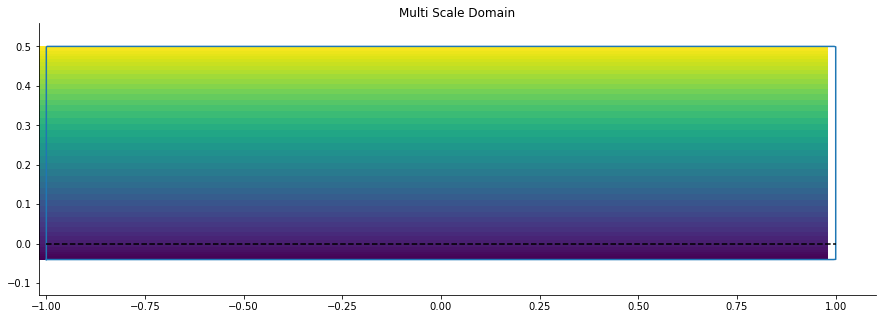

In [2]:
# Hard coded
eps = 0.04
dom = [[-1.,1.], [0, 0.5]]
bbox = [dom[0], [dom[1][0]-eps, dom[1][1]]]

# Not hard coded
Lx = dom[0][1] - dom[0][0]


# Fnctions
f = lambda x: np.zeros_like(x) - eps
df = lambda x: np.zeros_like(x)
ddf = lambda x: np.zeros_like(x)
g = lambda x: np.ones_like(x)

usol = lambda x,y: g(x) * (y - bbox[1][0]) /(bbox[1][1] - bbox[1][0])
dy_usol = lambda x,y: g(x) / (bbox[1][1] - bbox[1][0])
#usol = lambda x, y: uflat(x.flatten(), y.flatten()).reshape(x.size)
vsol = lambda x,y: np.zeros_like(x)
true_alpha = lambda x: -usol(x, np.zeros_like(x)) / dy_usol(x, np.zeros_like(x))

usol_basis = SSBasisProduct.fromFunctionInDomain(usol, bbox, 51, 51, FourBasis, ChebBasis)
vsol_basis = SSBasisProduct.fromFunctionInDomain(vsol, bbox, 51, 51, FourBasis, ChebBasis)

# Plot
data = StokesData(f, df, ddf, g, dom)
vmin, vmax= 0, .5
plt.figure(figsize=(15,5))
plt.title("Multi Scale Domain")
usol_basis.plot(plt.gca())
data.plot(plt.gca())
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.axis("equal")
plt.ylim([dom[1][0]-0.12, dom[1][1]+0.05])

## Coupling to Micro Domain

To couple the macro domain to the microscopic domain, we make use of the HMM framework.
We construct a set of evenly spaced micro problems based on the Stokes data. The macro problem is constructed with a pre-specified resolution in the x- and y-directions.

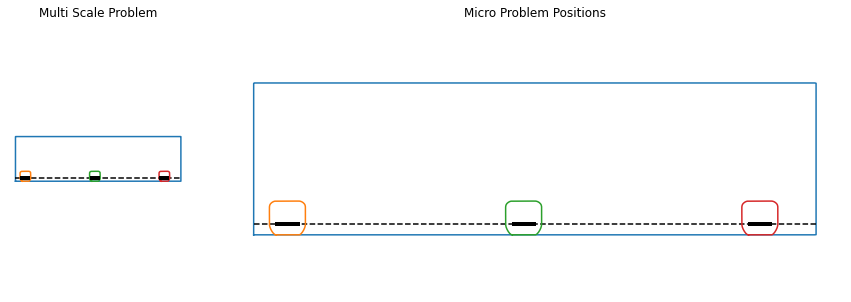

In [3]:
# Macro problem
xDim = 31
yDim = 23
iDeg = 13 #nMic*2 +1
macro = StokesMacProb(data, 
                      lambda x,a: trig_interp(x,a, iDeg, L=dom[0][1]-dom[0][0]),
                     alpha0 = true_alpha)

# Micro problems
nMic = 3
xPos = np.linspace(dom[0][0]+4*eps, dom[0][1]-4*eps, nMic)-2*eps
micros = [StokesMicProb(data, x, 2*eps, 2*eps, 0.0) for x in xPos]

# Hmm problem.
hmm_prob = StokesHMMProblem(macro, micros, data)

## PLOT ##

plt.figure(figsize=(15,5))

plt.subplot2grid((1,4), (0,0), colspan=1)
plt.title("Multi Scale Problem")
hmm_prob.plot(plt.gca())
plt.axis("Equal")
remove_axes(plt.gca())

plt.subplot2grid((1,4), (0,1), colspan=3)
plt.title("Micro Problem Positions")
hmm_prob.plot(plt.gca())
plt.axis("Equal")
remove_axes(plt.gca())
#plt.xlim([-eps,1 + eps])
#plt.ylim([-1-1*eps, -1+6*eps])

## Sanity check that true solution is fix point

## Solving using HMM iterations

To solve the problem, we make use of a sequence of micro solvers, as well as a micro solver.

In [4]:
class Callback():
    def __init__(self, macro):
        self.N = 100
        self.x = np.linspace(0,1,self.N)
        self.macro = macro
        self.current_alpha = macro.alpha(self.x)
        self.diff = []
    
    def __call__(self, it, macro_sol, micro_sols):
        self.previous_alpha = self.current_alpha
        self.current_alpha = self.macro.alpha(self.x)
        self.diff.append(np.linalg.norm(self.previous_alpha - self.current_alpha) / self.N**0.5)
        
debug_cb = Callback(macro)

print("Precomputing...")
macro_solver = MacroSolver(xDim, yDim)
micro_solvers = [MicroSolver(m) for m in micros]
hmm_solver = IterativeHMMSolver(macro_solver, micro_solvers)
print("Done")

Precomputing...
Done


# Validate micro problems

Test cases

In [6]:
m = micros[1]
ms = micro_solvers[1]
geom = m.geom
grid = geom.grid

s = 0.4
w = -np.exp(1j * 0.1*np.pi)
rotate = lambda z: w * z
unrotate = lambda z: z / w
sol = lambda z: usol(np.real(z).flatten(), np.imag(z).flatten()).reshape(z.size)

condition = lambda t: sol(geom.eval_param(t=t))#+ (1+1j)*np.ones(t.shape, dtype=np.complex128)

m.condition = condition

a = geom.line_left
b = geom.line_right

# Define grid, geometry and problem objects


# Problem 1: u(z) = conj(z)
problem = StokesDirichletProblem(condition=condition, geometry=geom)
problem.solve(tol=1e-5)
riesz_vec, func = geom.precompute_line_avg(tol=1e-10, maxiter=200)
riesz_vec2, func2 = geom.precompute_line_avg(derivative=1, tol=1e-10, maxiter=200)
riesz_vec3, func3 = geom.line_eval_adjoint(derivative=1, tol=1e-10, maxiter=200)

t,_ = grid.get_grid_and_weights()
z = geom.eval_param()
cond_t = problem.condition(t)
x, y = np.real(z), np.imag(z)


mod = np.abs(b - a)
tan = (b - a) / mod
avg_anal = 1/(bbox[1][1]-bbox[1][0]) * mod * eps
davg_anal = 1/(bbox[1][1]-bbox[1][0]) * mod

cond_t = condition(t)
f = func(cond_t)
df = func2(cond_t)
df2 = func3(cond_t)

print(f"Analytic: {avg_anal}. Numerical: {f}")
print(f"Analytic deriv: {davg_anal}. Numerical: {df}")
print(f"Analytic deriv: {davg_anal}. Numerical: {df2}")
print(f"Diff: {np.abs(avg_anal - f)}")
print(f"Analytic slip: {avg_anal / davg_anal}. Numerical: {ms.solve(m).alpha}, True Num: {f/df}")

Analytic: 0.005333333333333333. Numerical: 0.005333332483069834
Analytic deriv: 0.13333333333333333. Numerical: 0.13333333018372578
Analytic deriv: 0.13333333333333333. Numerical: 3.229535154927743e-10
Diff: 8.50263499364845e-10
Analytic slip: 0.04. Numerical: -0.04000004452076296, True Num: 0.03999999456790589


-0.040000057768195756


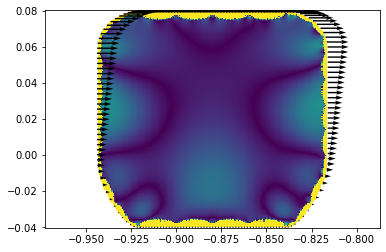

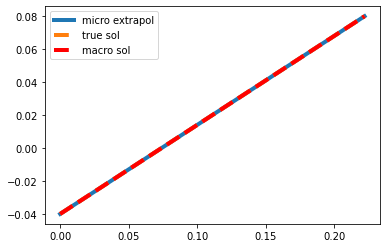

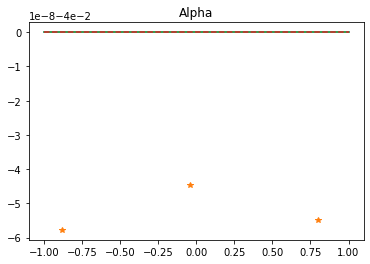

In [8]:
macro_guess = macro_solver.solve(macro)
microps = []
for m in micros:
    m.update(macro_guess)
    def cond(t):
        z = m.geom.eval_param(t=t)
        x,y = np.real(z), np.imag(z)
        return usol(x.flatten(), y.flatten()).reshape(x.size)
    m.condition=cond
    p = StokesDirichletProblem(m.geom, m.condition)
    p.solve()
    microps.append(p)
    
        
micro_sols = [ms.solve(m) for ms, m in zip(micro_solvers, micros)]
print(micro_sols[0].alpha)

tol = 1e-6
#field = lambda z: np.real(microps[0].evaluate(z)) 
field = lambda z: np.abs(np.real(microps[0].evaluate(z)) - usol(np.real(z).flatten(), np.imag(z).flatten()).reshape(z.size))
micros[0].geom.plot_field(plt.gca(), field, apply_mask=True, vmin=0, vmax=tol)
micros[0].geom.plot_field_on_boundary(plt.gca(), micros[0].condition)
plt.axis("equal")


plt.figure()
cond = lambda t: np.real(micros[0].condition(t))
ycord = lambda t: np.imag(micros[0].geom.eval_param(t=t))
t = np.linspace(0,np.pi,100)
yc = ycord(t)
plt.plot(cond(t), yc, label='micro extrapol', linewidth=4)
plt.plot(usol_basis(np.zeros_like(t), ycord(t)), yc, '--', label='true sol', linewidth=4)
plt.plot(macro_guess.u(np.zeros_like(t), ycord(t)), yc, 'r--',label='macro sol', linewidth=4)
plt.legend()


plt.figure()
plt.title("Alpha")
x = np.linspace(dom[0][0],dom[0][1],100)
a = macro.alpha(x)
xm = np.array([sol.x for sol in micro_sols])
am = np.array([sol.alpha for sol in micro_sols])
plt.plot(x, a, label='macro alpha')
plt.plot(xm, am, '*', label='micro alpha')
plt.plot(x, -eps * np.ones_like(x))
plt.plot(x, true_alpha(x), '--', label='true alpha')


In [8]:
macro.alpha = lambda t: np.zeros_like(t)

print("HMM Solver...")
macro_guess = macro_solver.solve(macro)
(macro_sol, micro_sols) = hmm_solver.solve(hmm_prob, macro_guess=macro_guess, 
                                           callback=debug_cb, verbose=True, maxiter=15)

print("\nDone")

HMM Solver...
Step 14/15
Done


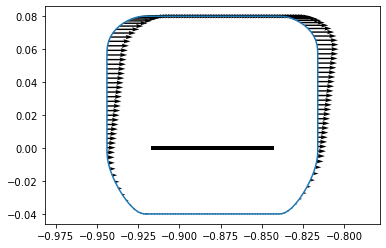

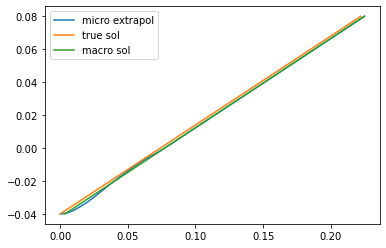

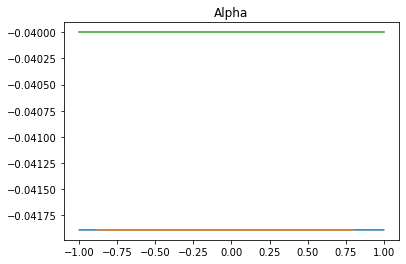

In [9]:
micros[0].plot(plt.gca())
micros[0].geom.plot_field_on_boundary(plt.gca(), micros[0].condition)
plt.axis("equal")


plt.figure()
cond = lambda t: np.real(micros[0].condition(t))
ycord = lambda t: np.imag(micros[0].geom.eval_param(t=t))
t = np.linspace(0,np.pi,100)
yc = ycord(t)
plt.plot(cond(t), yc, label='micro extrapol')
plt.plot(usol_basis(np.zeros_like(t), ycord(t)), yc, label='true sol')
plt.plot(macro_sol.u(np.zeros_like(t), ycord(t)), yc, label='macro sol')
plt.legend()




plt.figure()
plt.title("Alpha")
x = np.linspace(dom[0][0],dom[0][1],100)
a = macro.alpha(x)
xm = np.array([sol.x for sol in micro_sols])
am = np.array([sol.alpha for sol in micro_sols])
plt.plot(x, a)
plt.plot(xm, am)
plt.plot(x, true_alpha(x))


## Convergence study for slip coefficient

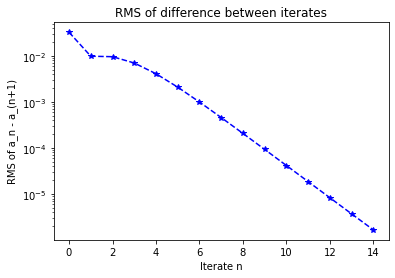

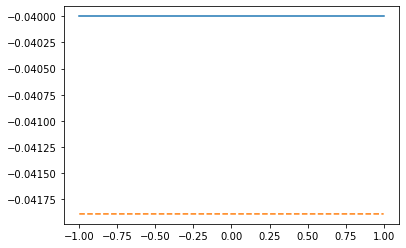

In [10]:
plt.figure()
plt.title("RMS of difference between iterates")
plt.semilogy(debug_cb.diff, 'b*--')
plt.xlabel("Iterate n")
plt.ylabel("RMS of a_n - a_(n+1)")

plt.figure()
x = np.linspace(dom[0][0], dom[0][1], 100)
plt.plot(x, true_alpha(x))
plt.plot(x, macro.alpha(x), '--')

## Prepare comparison
We use the reference solver data to construct a piecewise linear interpolation. Also, the micro data is used to construct a set of full solutions to the velocity field in the micro problems for visualisation purposes.

In [11]:
full_micro_sols = []
for m in micros:
    prob = StokesDirichletProblem(m.geom, m.condition)
    prob.solve()
    full_micro_sols.append(prob)

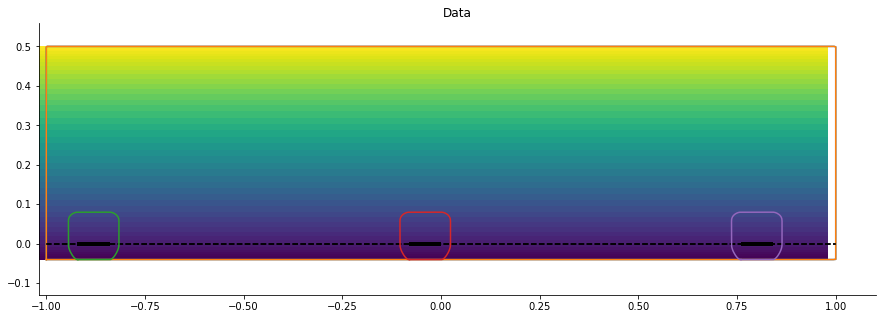

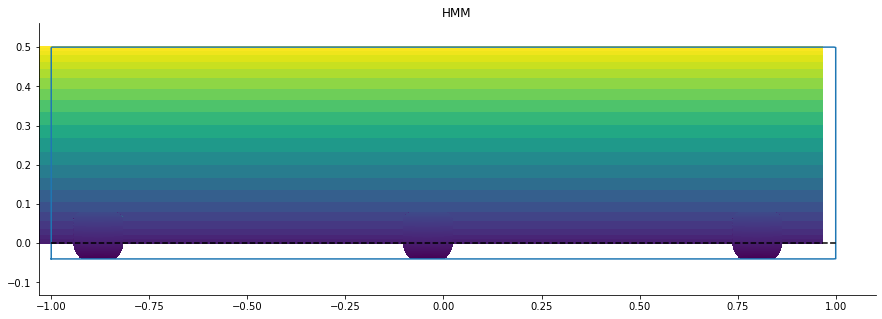

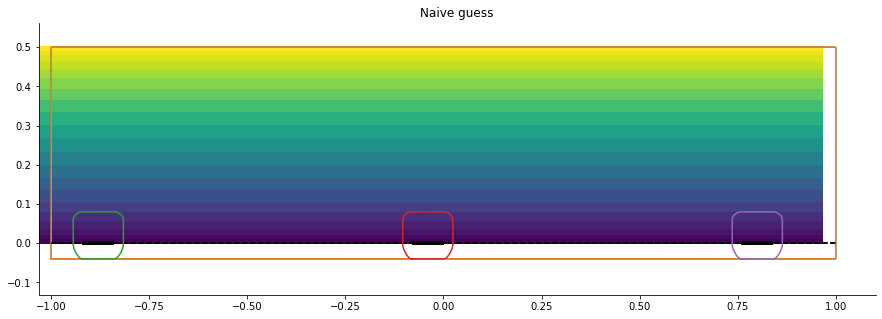

In [12]:
vmax, vmin = 1., 0.

plt.figure(figsize=(15,5))
plt.title("Data")
usol_basis.plot(plt.gca(), vmax=vmax, vmin=vmin)
data.plot(plt.gca())
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.axis("equal")
plt.ylim([dom[1][0]-0.12, dom[1][1]+0.05])
hmm_prob.plot(plt.gca())

plt.figure(figsize=(15,5))
plt.title("HMM")
macro_sol.u.plot(plt.gca(), vmin=vmin, vmax=vmax)
data.plot(plt.gca())
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.axis("equal")
plt.ylim([dom[1][0]-0.12, dom[1][1]+0.05])
for m, s in zip(micros, full_micro_sols):
    m.geom.plot_field(plt.gca(), lambda z: np.real(s.evaluate(z)), apply_mask=True, vmin=vmin, vmax=vmax)
#hmm_prob.plot(plt.gca(), color='black', linewidth=1)



plt.figure(figsize=(15,5))
plt.title("Naive guess")
macro_guess.u.plot(plt.gca(), vmin=vmin, vmax=vmax)
data.plot(plt.gca())
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.axis("equal")
plt.ylim([dom[1][0]-0.12, dom[1][1]+0.05])
hmm_prob.plot(plt.gca(), color='black', linewidth=1)

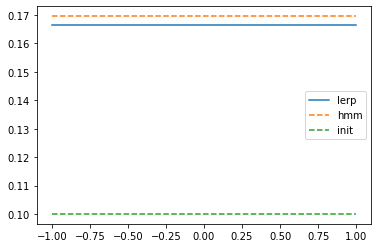

In [13]:
plt.figure()
#yfix = dom[1][1]-np.ones_like(xhd)*0.02
xhd = np.linspace(-1,1,100)
yfix = np.ones_like(xhd)*0.05
#plt.plot(xmac, Umac[53,:], label='true')
plt.plot(xhd, usol_basis(xhd, yfix), label='lerp')#, linestyle='--')
plt.plot(xhd, macro_sol.u(xhd, yfix), linestyle='--', label='hmm')
plt.plot(xhd, macro_guess.u(xhd, yfix), linestyle='--', label='init')

plt.legend()

# a f(x) + b = g(x)
# a f(y) + b = g(y)
# a = (g(x) - g(y)) / (f(x) - f(y))
#x1 = np.array([0.2,0.4])
#y1 = np.zeros_like(x1) + 0.1
#f = pwlerp(x1, y1)
#g = macro_sol.u(x1, y1)

#a = (g[0]-g[1]) / (f[0] - f[1])
#b = g[0] - a*f[1]
#print(b)


Verifying derivatives

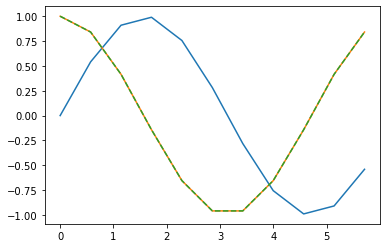

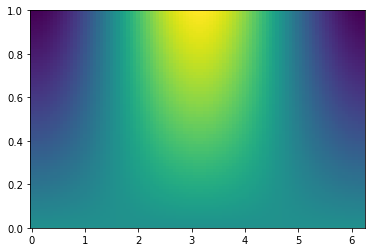

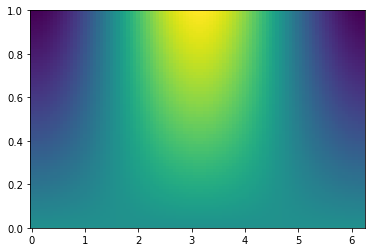

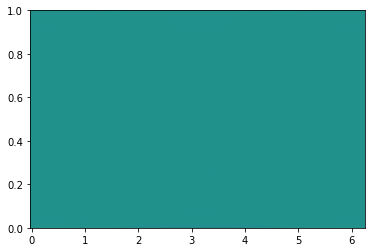

In [14]:
f = lambda x: np.sin(x)
df = lambda x: np.cos(x)

basis = SSBasis.fromFunction(f, 2*np.pi, 0, FourBasis, 11)
dbasis = SSBasis.fromFunction(df, 2*np.pi, 0, FourBasis, 11)
#basis = FourBasis.fromFunction(f, 11)


basis.plot(plt.gca(), 11)
dbasis.plot(plt.gca(), 11)
basis.diff(1).plot(plt.gca(), 11, linestyle='--')


#f = lambda x,y: np.sin(2*np.pi*x)*np.cos(2*np.pi*y)
f = lambda x,y: np.sin(x)*np.cos(y)
dx_f = lambda x,y: np.cos(x)*np.cos(y)
dxy_f = lambda x,y: -f(y,x)
scale = [2*np.pi,1.]
shift = [0.,0.]

#help(ScaleShiftedBasisProduct)
basis = SSBasisProduct.fromFunctionInDomain(f, [[0,2*np.pi], [0,1]], 
                                    101, 101, FourBasis, ChebBasis)
#basis = BasisProduct.fromFunction(f, 101, 101, FourBasis, ChebBasis)
dx_basis = basis.diff(1, 1)

plt.figure()
dx_basis.plot(plt.gca())


X, Y = basis.grid()
plt.figure()
plt.pcolormesh(X, Y, dxy_f(X,Y))

plt.figure()
plt.pcolormesh(X,Y,dxy_f(X,Y)-
               dx_basis.eval_grid())
